# Library & directory 준비하기

In [7]:
# version check
import os #ver.
import sys #ver.
import platform #ver.
import warnings #ignore

# EDA
import pandas as pd #dataframe
import numpy as np #linear algebra
from PIL import Image #image
import matplotlib as mpl #viz.
import matplotlib.pyplot as plt #viz.

# Module
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [8]:
# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Python Version: {platform.python_version()}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")

Current OS: Linux
CUDA: True
Python Version: 3.8.5
torch Version: 1.7.1
torchvision Version: 0.8.2


## train data 준비하기

In [12]:
train_dir = 'input/data/train'
train_csv_dir = os.path.join(train_dir,'train.csv')
train_images_dir = os.path.join(train_dir,'images')

print("csv directory:",train_csv_dir)
print("images directory:",train_images_dir)

csv directory: input/data/train/train.csv
images directory: input/data/train/images


In [163]:
trainset = pd.read_csv(train_csv_dir)
trainset.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


## file directory 설정
디렉토리 다루는 것도 어렵다
- input->...->path->1명당 7장의 사진(incorrect 1장, mask 5장, normal 1장)

In [15]:
os.listdir(train_images_dir)[:5]

['003891_female_Asian_31',
 '003069_female_Asian_19',
 '006477_female_Asian_18',
 '._001456_male_Asian_57',
 '003135_female_Asian_20']

In [197]:
# incorrect, mask, normal은 모든 관찰자에 대해 존재하는 이미지 파일

images_type = sorted(os.listdir(os.path.join(train_images_dir,trainset['path'][0])))
print("디렉토리 안 전체 이미지는 {}개\n{}\n".format(len(images_type),images_type))

images_type = [im_dir for im_dir in images_type if not im_dir.startswith('.')]
print("사용할 이미지는 {}개\n{}\n".format(len(images_type),images_type))

print("이미지 directory 예시\n",os.path.join(train_images_dir,trainset['path'][0],images_type[0]))

디렉토리 안 전체 이미지는 14개
['._incorrect_mask.jpg', '._mask1.jpg', '._mask2.jpg', '._mask3.jpg', '._mask4.jpg', '._mask5.jpg', '._normal.jpg', 'incorrect_mask.jpg', 'mask1.jpg', 'mask2.jpg', 'mask3.jpg', 'mask4.jpg', 'mask5.jpg', 'normal.jpg']

사용할 이미지는 7개
['incorrect_mask.jpg', 'mask1.jpg', 'mask2.jpg', 'mask3.jpg', 'mask4.jpg', 'mask5.jpg', 'normal.jpg']

이미지 directory 예시
 input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg


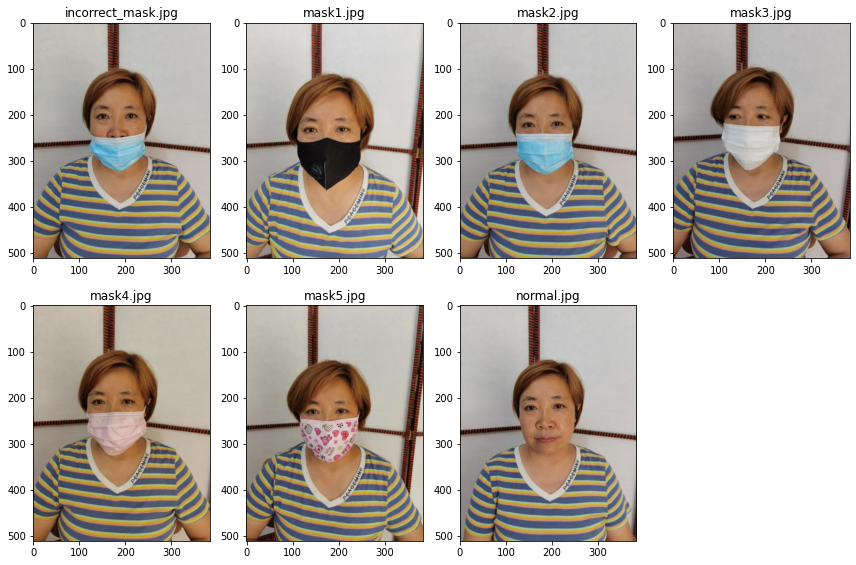

In [46]:
plt.figure(figsize=(12,8))

for n in range(7):
    im_dir = os.path.join(train_images_dir,trainset['path'][0],images_type[n])
    im = Image.open(im_dir)
    
    plt.subplot(2,4,n+1)
    plt.imshow(im)
    plt.title("{}".format(images_type[n]))

plt.tight_layout()
plt.show()

- 1명의 타겟은 총 7장의 이미지를 가진다.
    - 구도와 배경이 동일하지만 정확한 위치는 아주 미세하게 차이가 있다-->이 정도는 조정 가능할 듯
    - 같은 mask 이미지여도 마스크의 **색상, 모양, 무늬가 모두 다르다**-->색상 차이는 활용하지 않고, 아예 색상 차이를 제거하는 것이 좋을 듯(ToGray 등)

# input X 분석

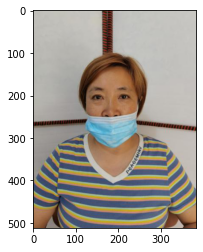

In [58]:
im = Image.open(os.path.join(train_images_dir,trainset['path'][0],images_type[0]))

plt.figure(figsize=(4,4))
plt.imshow(im)
plt.show()

## 이미지 사이즈

In [59]:
# 샘플 이미지 1장의 사이즈
print(im.size)

(384, 512)


In [60]:
# 샘플 이미지 7장의 사이즈 확인
im_dir = [os.path.join(train_images_dir,trainset['path'][0],image_name) for image_name in images_type]

for dr in im_dir:
    ims = Image.open(dr)
    print(ims.size)

(384, 512)
(384, 512)
(384, 512)
(384, 512)
(384, 512)
(384, 512)
(384, 512)


In [61]:
# 샘플 이미지 7장의 사이즈 확인
im_dir = [os.path.join(train_images_dir,trainset['path'][n],images_type[0]) for n in range(5)]

for dr in im_dir:
    ims = Image.open(dr)
    print(ims.size)

(384, 512)
(384, 512)
(384, 512)
(384, 512)
(384, 512)


이미지 크기는 (384,512)로 맞춰진 것 같다

## RGB 채널별 통계 값
> R,G,B를 분리했을 때의 통계값에 유의미한 차이가 있을까?

In [83]:
# PIL로 pixel rgb 구하기
# https://stackoverflow.com/questions/11064786/get-pixels-rgb-using-pil

im_rgb = im.convert('RGB')
im_rgb.getpixel((1, 1))

(384, 512)


(191, 190, 185)

In [254]:
# numpy array로 변환 후 r,g,b 분리하기

im_np = np.array(im_rgb)
print(im_np.shape)

# Split
red = im_np[:, :, 0]
green = im_np[:, :, 1]
blue = im_np[:, :, 2]

print(red.shape, green.shape, blue.shape)

(512, 384, 3)
(512, 384) (512, 384) (512, 384)


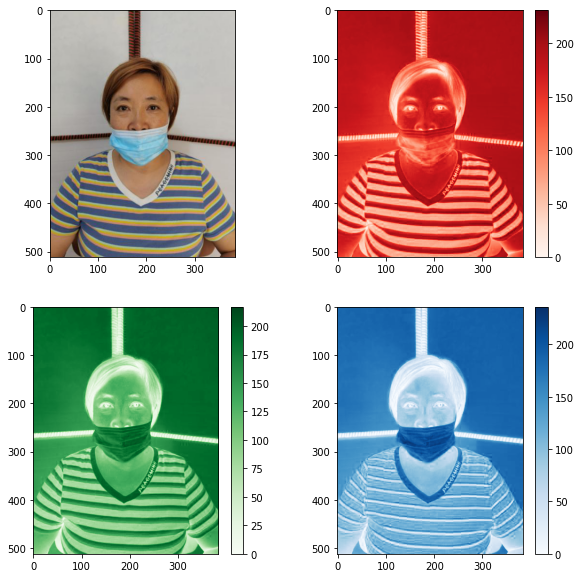

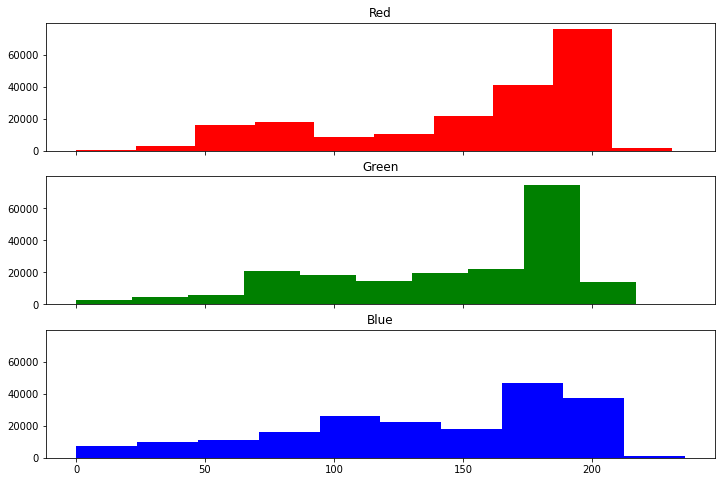

In [185]:
# RGB 분리해서 plot그리기
# https://stackoverflow.com/questions/39885178/how-can-i-see-the-rgb-channels-of-a-given-image-with-python

# RGB 분리해서 이미지로 그리기
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,10)

cax_00 = axs[0,0].imshow(im_np)
# axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
# axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
# axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
# axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
# axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
# axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
# axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
# axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

# RGB 히스토그램 그리기
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(12,8)

axs[0].hist(red.ravel(), bins=10, color='r')
axs[0].set_title('Red')
axs[1].hist(green.ravel(), bins=10, color='g')
axs[1].set_title('Green')
axs[2].hist(blue.ravel(), bins=10, color='b')
axs[2].set_title('Blue')

plt.show()

히스토그램을 보면 rgb 분포에 큰 차이는 없어 보인다.

In [204]:
pd.DataFrame(red).describe()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,163.673828,163.757812,164.365234,164.787109,164.343750,163.746094,163.496094,163.480469,163.496094,163.511719,...,185.755859,186.111328,186.593750,186.703125,187.087891,187.027344,186.789062,187.501953,188.935547,190.488281
std,34.973530,34.040898,32.433786,31.801728,33.306661,35.619400,36.305078,35.508545,34.169887,33.479962,...,32.029966,30.573406,28.146719,27.358277,26.310395,26.836448,28.667922,27.953274,23.863230,21.124083
min,0.000000,34.000000,50.000000,47.000000,41.000000,7.000000,0.000000,13.000000,55.000000,56.000000,...,6.000000,17.000000,45.000000,70.000000,69.000000,45.000000,12.000000,25.000000,37.000000,33.000000
25%,155.000000,155.000000,155.000000,156.000000,156.000000,155.000000,155.000000,154.750000,154.000000,154.000000,...,194.000000,194.000000,195.000000,195.000000,194.000000,194.750000,194.000000,194.000000,195.000000,195.000000
50%,178.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.500000,177.000000,178.000000,178.000000,...,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
75%,184.000000,184.000000,184.000000,184.000000,185.000000,185.000000,185.000000,185.000000,185.250000,185.000000,...,197.000000,197.000000,198.000000,197.250000,197.250000,197.000000,197.000000,198.000000,198.000000,198.000000
max,200.000000,199.000000,194.000000,193.000000,193.000000,198.000000,205.000000,209.000000,214.000000,211.000000,...,203.000000,206.000000,212.000000,213.000000,217.000000,213.000000,208.000000,207.000000,209.000000,216.000000


In [208]:
print(red.min(), red.max(), red.mean(), red.std())
print(green.min(), green.max(), green.mean(), green.std())
print(blue.min(), blue.max(), blue.mean(), blue.std())

0 231 153.9891153971354 48.70481882279441
0 217 146.30484008789062 49.60605363892835
0 236 136.09719848632812 54.11230500940445


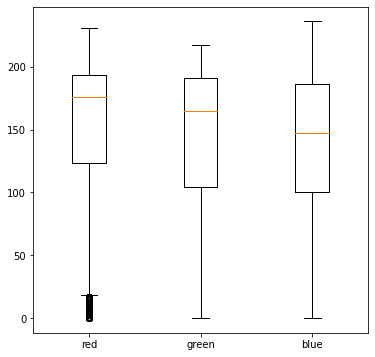

In [255]:
# sample 이미지 1장의 r,g,b의 boxplot 그려서 확인하기

plt.figure(figsize=(6,6))

plt.boxplot([red.flatten(), green.flatten(), blue.flatten()])
plt.xticks([1,2,3],labels=['red','green','blue'])

plt.show()

- blue의 boundary가 가장 길지만 통계적 유의미한 차이를 찾기는 힘들다고 판단

### mask 카테고리에 따라 rgb 분포 비교하기

(512, 384, 3) (512, 384, 3)


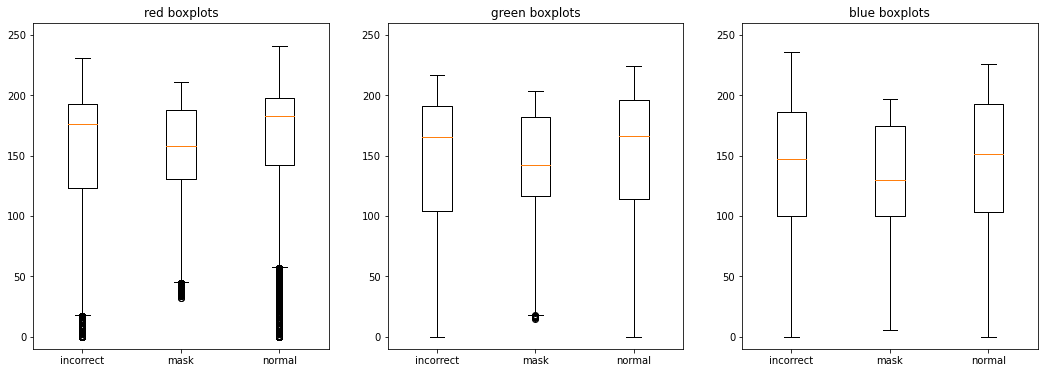

In [256]:
# target 1명의 이미지 7장-->3가지 category(incorrect,mask,normal)로 나누어 rgb 분포 비교하기

sample_images_path = [os.path.join(train_images_dir,trainset['path'][0],file) for file in images_type]
#print(sample_images_path)
sample_images = [np.array(Image.open(sample_image_dir)) for sample_image_dir in sample_images_path]
#sample_images

#images_type-->(0)incorrect (1:-1)mask (-1)normal
im_incorrect = sample_images[0]
im_mask = np.mean(sample_images[1:-1],axis=0)
im_normal = sample_images[-1]
print(im_incorrect.shape, im_mask.shape)

red_incorrect = im_incorrect[:,:,0].flatten()
red_mask = im_mask[:,:,0].flatten()
red_normal = im_normal[:,:,0].flatten()

green_incorrect = im_incorrect[:,:,1].flatten()
green_mask = im_mask[:,:,1].flatten()
green_normal = im_normal[:,:,1].flatten()

blue_incorrect = im_incorrect[:,:,2].flatten()
blue_mask = im_mask[:,:,2].flatten()
blue_normal = im_normal[:,:,2].flatten()

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.boxplot([red_incorrect, red_mask, red_normal])
plt.xticks([1,2,3],labels=['incorrect','mask','normal'])
plt.title('red boxplots')
plt.ylim(-10,260)

plt.subplot(1,3,2)
plt.boxplot([green_incorrect, green_mask, green_normal])
plt.xticks([1,2,3],labels=['incorrect','mask','normal'])
plt.title('green boxplots')
plt.ylim(-10,260)

plt.subplot(1,3,3)
plt.boxplot([blue_incorrect, blue_mask, blue_normal])
plt.xticks([1,2,3],labels=['incorrect','mask','normal'])
plt.title('blue boxplots')
plt.ylim(-10,260)

plt.show()

- 전체적인 분포에 차이가 있는지는 boxplot만 봐서 결론짓기 어렵다.
    - red, green, blue에 따른 차이는 크지 않다
    - incorrect와 mask, normal에 따른 차이는 어느 정도 존재하는 것으로 보인다. 하지만 통계적 유의성을 결론 짓기에는 부족하다.
    - mask의 boundary에 차이가 있어 보이지만, 이는 5개 mask 사진의 mean값의 분포이기 때문에 나타나는 차이일 수 있다.

rgb 분포에 대해 통계적으로 유의미한 결과를 기대하기는 어려워 보인다.(-->더 분석할지 말지)
- 하지만 1명의 target도 다양한 색상과 형태의 마스크를 쓰고 있기 때문에 **<u>`torchvision.transforms`으로 RGB 관련 scaling을 진행해볼 수 있다</u>**
- 각기 다른 target의 이미지는 밝기가 제각각.(어떤 건 밝고 어떤 건 어둡고)--><u>**밝기 generalization 작업도 필요할 것으로 보인다.**</u>


# target y 분석

## features

In [186]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         2700 non-null   object
 1   gender     2700 non-null   object
 2   race       2700 non-null   object
 3   age        2700 non-null   int64 
 4   path       2700 non-null   object
 5   age_group  2700 non-null   object
dtypes: int64(1), object(5)
memory usage: 126.7+ KB


In [187]:
trainset.describe(include='all')

,id,gender,race,age,path,age_group
count,2700,2700,2700,2700.000000,2700,2700
unique,2699,2,1,NaN,2700,3
top,003397,female,Asian,NaN,005002_female_Asian_28,<30
freq,2,1658,2700,NaN,1,1281
mean,NaN,NaN,NaN,37.708148,NaN,NaN
std,NaN,NaN,NaN,16.985904,NaN,NaN
min,NaN,NaN,NaN,18.000000,NaN,NaN
25%,NaN,NaN,NaN,20.000000,NaN,NaN
50%,NaN,NaN,NaN,36.000000,NaN,NaN
75%,NaN,NaN,NaN,55.000000,NaN,NaN


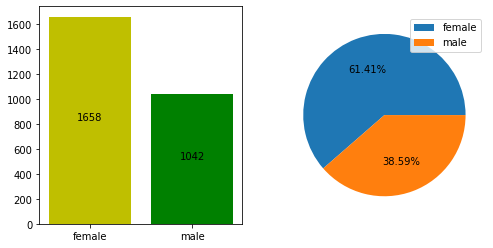

In [196]:
gender = trainset['gender'].value_counts()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.bar(gender.index,gender,color=['y','g'])
plt.text(0,gender['female']/2,s=str(gender['female']),horizontalalignment='center')
plt.text(1,gender['male']/2,s=str(gender['male']),horizontalalignment='center')

plt.subplot(1,2,2)
plt.pie(gender,autopct=lambda p : '{:.2f}%'.format(p))
plt.legend(gender.index)

plt.show()

- female이 male보다 높은 비율을 차지한다

In [115]:
trainset['race'].value_counts()

Asian    2700
Name: race, dtype: int64

- 인종은 Asian 밖에 없다. 다양했으면 어렵지만 재밌지 않았을까

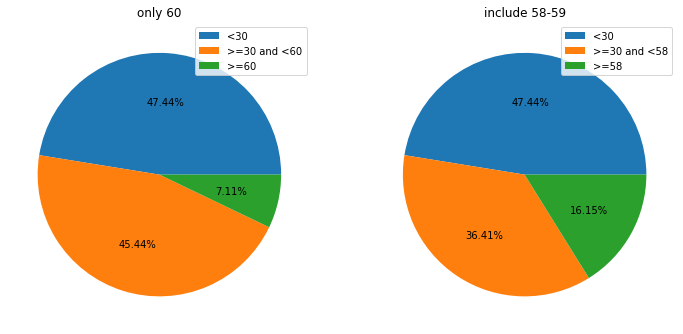

In [275]:
#### 60세 이상<--그대로 60세만 포함

trainset.loc[(trainset.age < 30),  'age_group'] = '<30'
trainset.loc[(trainset.age >= 30),  'age_group'] = '>=30 and <60'
trainset.loc[(trainset.age >= 60),  'age_group'] = '>=60'

age_group = trainset['age_group'].value_counts()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.pie(age_group,autopct=lambda p : '{:.2f}%'.format(p))
plt.legend(age_group.index)
plt.title('only 60')

#### 60세 이상<---58-59세도 포함해서 확인

trainset.loc[(trainset.age < 30),  'age_group'] = '<30'
trainset.loc[(trainset.age >= 30),  'age_group'] = '>=30 and <58'
trainset.loc[(trainset.age >= 58),  'age_group'] = '>=58'

age_group = trainset['age_group'].value_counts()

plt.subplot(1,2,2)
plt.pie(age_group,autopct=lambda p : '{:.2f}%'.format(p))
plt.legend(age_group.index)
plt.title('include 58-59')
plt.show()

60대 이상 그룹에 58-59세도 포함시키면 불균형이 조금 개선된다.

In [276]:
group = trainset.groupby('gender')['age_group'].value_counts().sort_index()
group

gender  age_group   
female  <30             732
        >=30 and <58    669
        >=58            257
male    <30             549
        >=30 and <58    314
        >=58            179
Name: age_group, dtype: int64

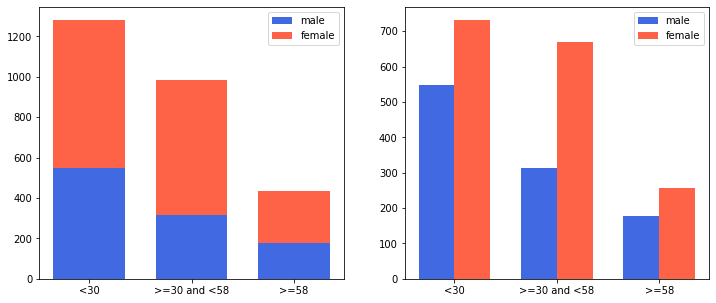

In [277]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(group['male'].index,group['male'],color='royalblue',label='male',width=0.7)
plt.bar(group['female'].index,group['female'],color='tomato',bottom=group['male'],label='female',width=0.7)

plt.legend()

plt.subplot(1,2,2)
idx = np.arange(len(group['male'].index)) #0~그룹 개수-1
width=0.35 #막대 두께 설정

plt.bar(idx-width/2, group['male'], color='royalblue', width=width, label='male') 
plt.bar(idx+width/2, group['female'], color='tomato', width=width, label='female')

plt.xticks(idx,labels=group['male'].index)

plt.legend()
plt.show()

- 연령 group별로 성별을 표시했을 때, 
    - 모든 연령 그룹에서 female 수가 더 많다

In [247]:
np.sort(trainset.age.unique())

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

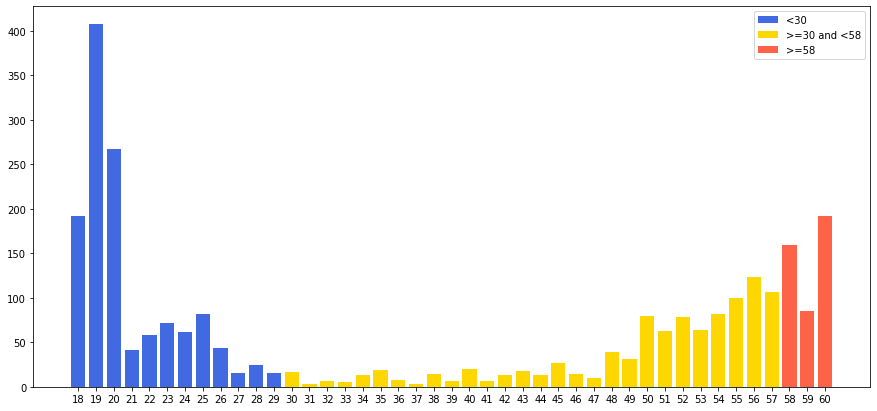

In [279]:
# Age
ages = trainset['age'].value_counts().sort_index()

plt.figure(figsize=(15,7))
plt.bar(ages.loc[:30].index,ages.loc[:30],color='royalblue',label='<30')
plt.bar(ages.loc[30:58].index,ages.loc[30:58],color='gold',label='>=30 and <58')
plt.bar(ages.loc[58:].index,ages.loc[58:],color='tomato',label='>=58')
plt.xticks(ages.index)
plt.legend()
plt.show()

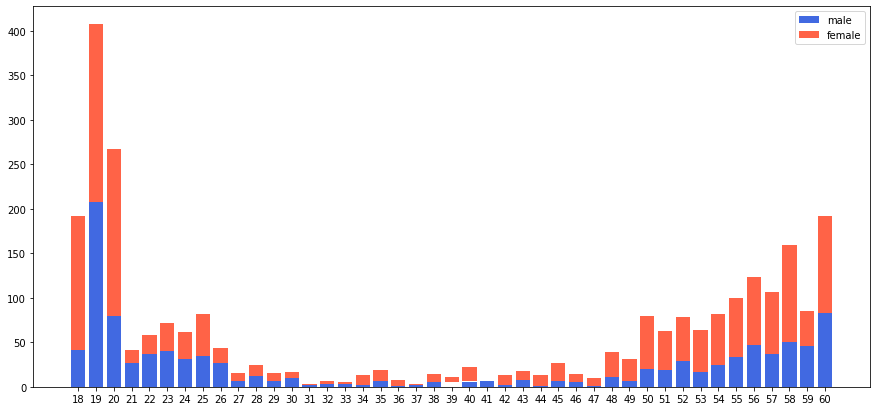

In [182]:
group = trainset.groupby('gender')['age'].value_counts().sort_index()

plt.figure(figsize=(15,7))

plt.bar(group['male'].index, group['male'],color='royalblue',label='male')
plt.bar(group['female'].index, group['female'],color='tomato',bottom=group['male'],label='female')

# plt.bar(ages.loc[:30].index,ages.loc[:30],color='royalblue',label='<30')
# plt.bar(ages.loc[30:60].index,ages.loc[30:60],color='gold',label='>=30 and <60')
# plt.bar(ages.loc[60:].index,ages.loc[60:],color='tomato',label='>=60')
plt.xticks(ages.index)
plt.legend()
plt.show()

# X & y
- 연령/성별에 따른 RGB 통계값 차이가 있는지
- 다른 target의 RGB 통계값 차이도 확인하기

In [222]:
trainset.head()

,id,gender,race,age,path,age_group
0,000001,female,Asian,45,000001_female_Asian_45,>=30 and <60
1,000002,female,Asian,52,000002_female_Asian_52,>=30 and <60
2,000004,male,Asian,54,000004_male_Asian_54,>=30 and <60
3,000005,female,Asian,58,000005_female_Asian_58,>=30 and <60
4,000006,female,Asian,59,000006_female_Asian_59,>=30 and <60


# 더 알아볼 것
- 밝기 generalization
- 마스크 색상 차이(검은 마스크, 하얀 마스크 등)에 따른 transforms 어떻게 하면 좋을지
- RGB 통계값에서 어떤 특징을 보면 좋을지 더 찾아보기